In [36]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from mlforecast import MLForecast

from sklearn.ensemble import RandomForestRegressor

from src.utils.split_series import split_series
from src.evaluation.evaluation import MetricEvaluator

In [37]:
pd.set_option("display.max_rows", None)
pd.set_option("display.max_columns", None)

In [38]:
df_brl = pd.read_parquet('../../../data/all_comm/all_commodities_brl.parquet')

In [39]:
df_brl.head()

,ds,y,unique_id
0,2020-01-02,65.40,ACUCAR_SANTOS
1,2020-01-03,66.80,ACUCAR_SANTOS
2,2020-01-06,68.92,ACUCAR_SANTOS
3,2020-01-07,68.85,ACUCAR_SANTOS
4,2020-01-08,68.32,ACUCAR_SANTOS


In [40]:
train, val, test = split_series(df_brl)

Splitted data into TRAIN with size 33235, VALIDATION with size 8312 and TEST with size 17814


In [41]:
model = RandomForestRegressor(
    n_estimators=5,
    min_samples_leaf=5,
    max_depth=5,
)

fcst = MLForecast(
    models={'rf': model},
    lags=[1, 2],
    freq='D'
)

# params found here https://www.nature.com/articles/s41598-024-74503-4/tables/7

In [42]:
# start tunning here if needed eventually

In [43]:
full_train = pd.concat([train, val])

In [44]:
fcst.fit(full_train)

MLForecast(models=[rf], freq=D, lag_features=['lag1', 'lag2'], date_features=[], num_threads=1)

In [45]:
# Rollout
forecasts = []
for i in range(len(test)):
    f_next = fcst.predict(h=1)
    forecasts.append(f_next)

    # add real value
    obs = test.iloc[[i]][['unique_id', 'ds', 'y']]
    fcst.update(obs)

In [46]:
forecasts_df = pd.concat(forecasts, ignore_index=True)

In [47]:
evaluator = MetricEvaluator()

In [48]:
results = evaluator.evaluate_multiple(
    forecasts_df=forecasts_df,    
    actual_df=test,                
    model_columns=['rf'],         
    groupby_column='unique_id'     
)

print(results)

         unique_id Model  n_observations         MAE      MAPE            MSE  \
0    ACUCAR_SANTOS    rf             306    4.857631  0.032269      33.320239   
1        ACUCAR_SP    rf            1657    4.841312  0.059625      31.205387   
2          ALGODAO    rf            3696    8.614445  0.030448      85.302810   
3            ARROZ    rf            5335    3.569269  0.074108      13.761991   
4     CAFE_ROBUSTA    rf            9184   27.105801  0.055787    9107.061005   
5            MILHO    rf           10784    0.621034  0.011642       2.238918   
6      SOJA_PARANA    rf           12740    1.711528  0.021621       4.357892   
7     TRIGO_PARANA    rf           15868   50.243163  0.041805   20473.815003   
8         TRIGO_RS    rf           17455   29.398832  0.022456   13846.749861   
9     CAFE_ARABICA    rf            1654  152.095411  0.095700  129090.610054   
10  SOJA_PARANAGUA    rf            1106    3.988515  0.027752      22.881210   

          RMSE        R2  


In [49]:
summary = evaluator.get_summary_stats(results)
print("\n=== Estatísticas Resumo ===")
print(summary)


=== Estatísticas Resumo ===
           MAE                                     MAPE                  \
          mean      std    min       max  median   mean     std     min   
Model                                                                     
rf     26.0952  44.6308  0.621  152.0954  4.8576  0.043  0.0256  0.0116   

                              MSE                                            \
          max  median        mean         std     min          max   median   
Model                                                                         
rf     0.0957  0.0323  15701.0277  38270.7445  2.2389  129090.6101  33.3202   

          RMSE                                        R2                 \
          mean      std     min       max  median   mean     std    min   
Model                                                                     
rf     68.0139  110.375  1.4963  359.2918  5.7724  0.789  0.2562  0.308   

                       
          max  median  
Mode

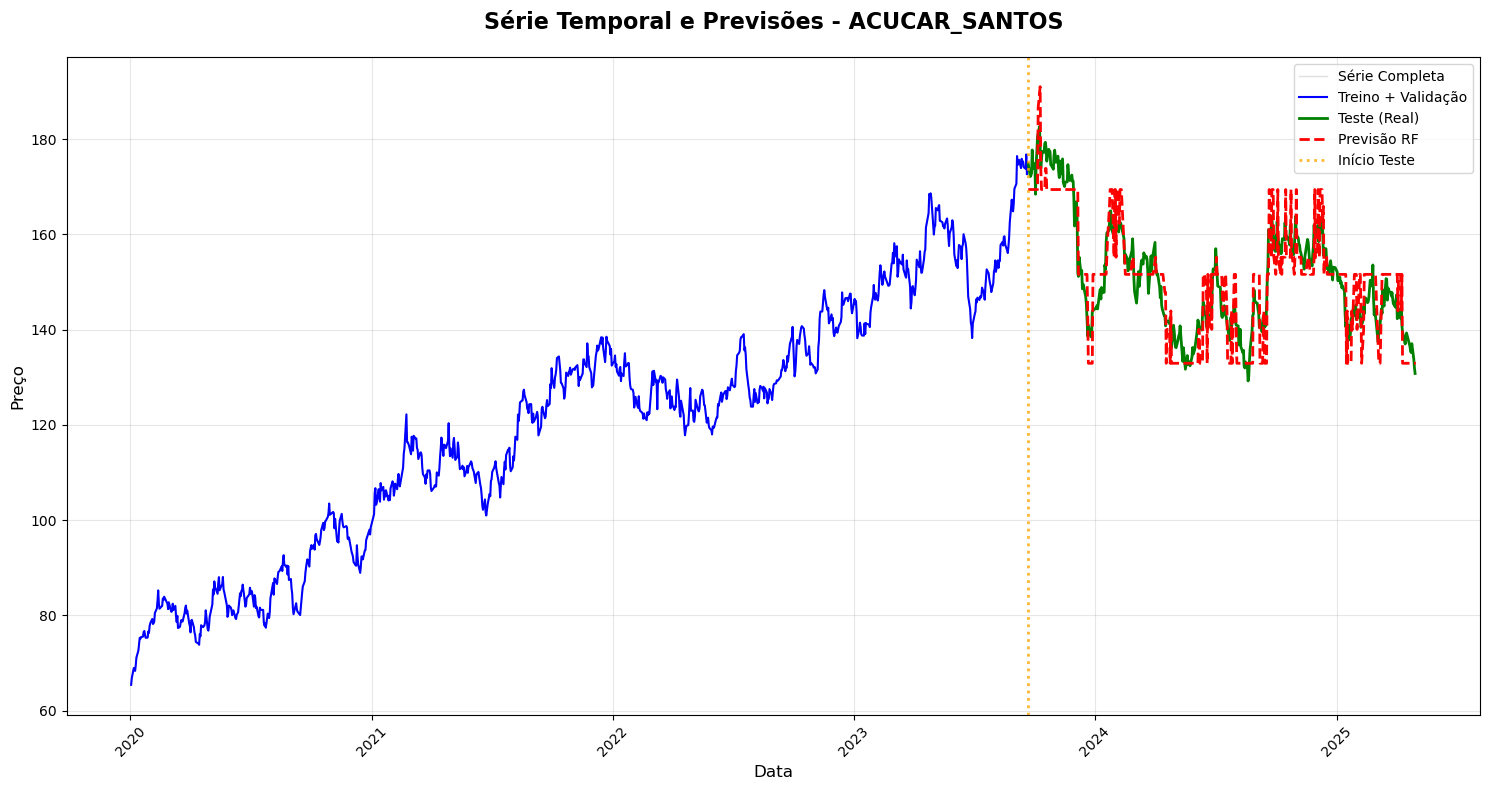

Gráfico exibido para: ACUCAR_SANTOS
--------------------------------------------------


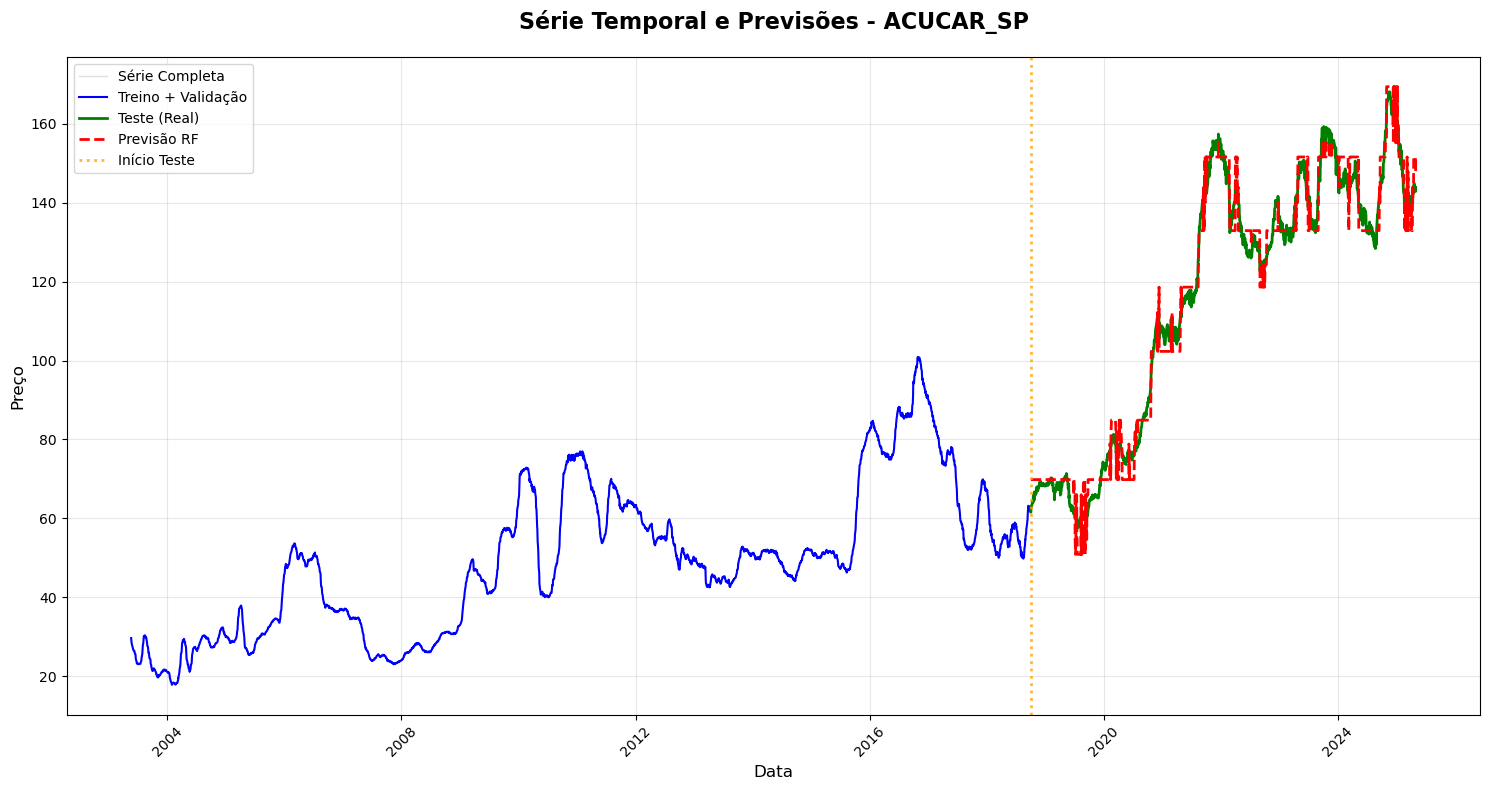

Gráfico exibido para: ACUCAR_SP
--------------------------------------------------


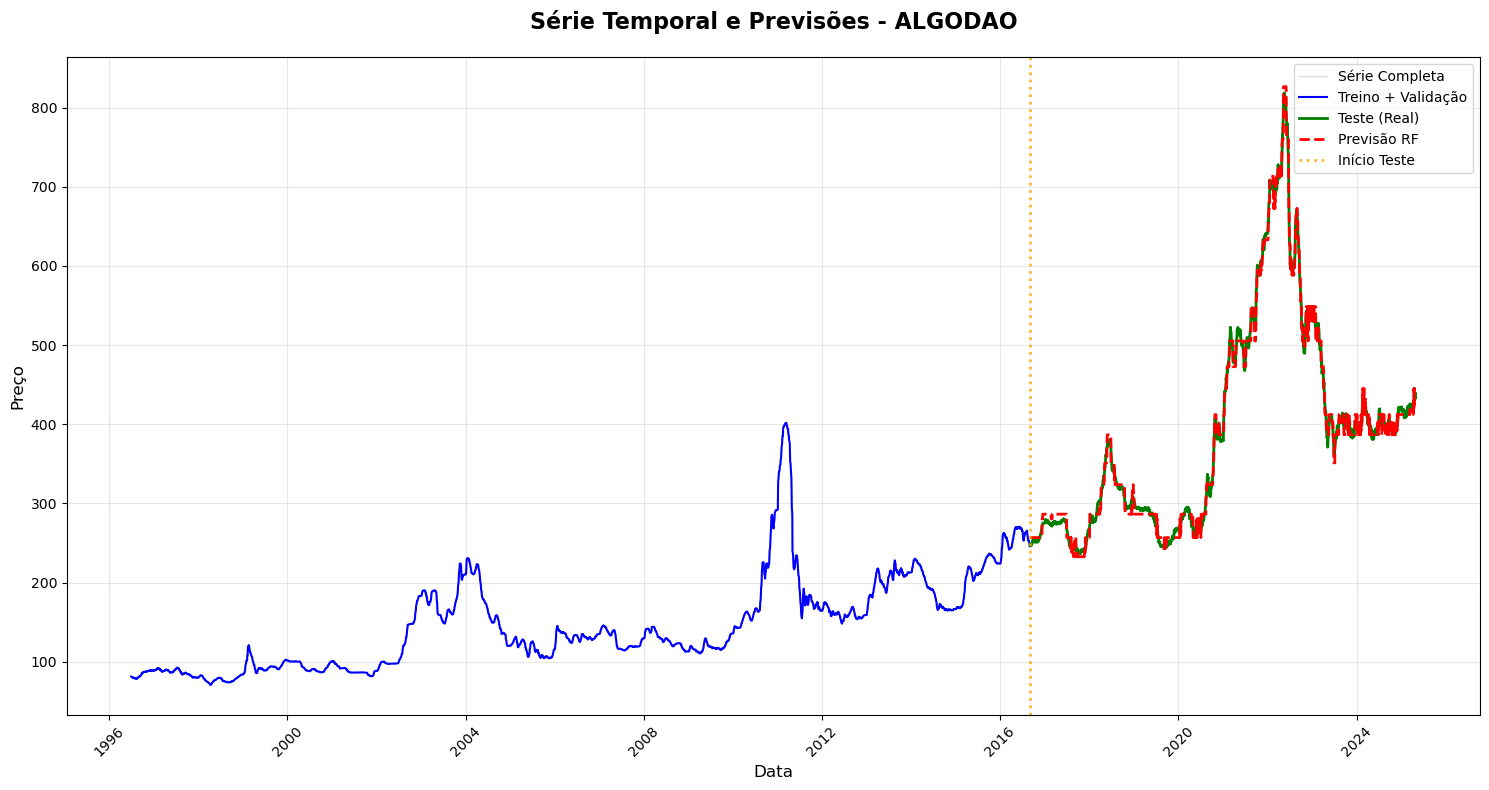

Gráfico exibido para: ALGODAO
--------------------------------------------------


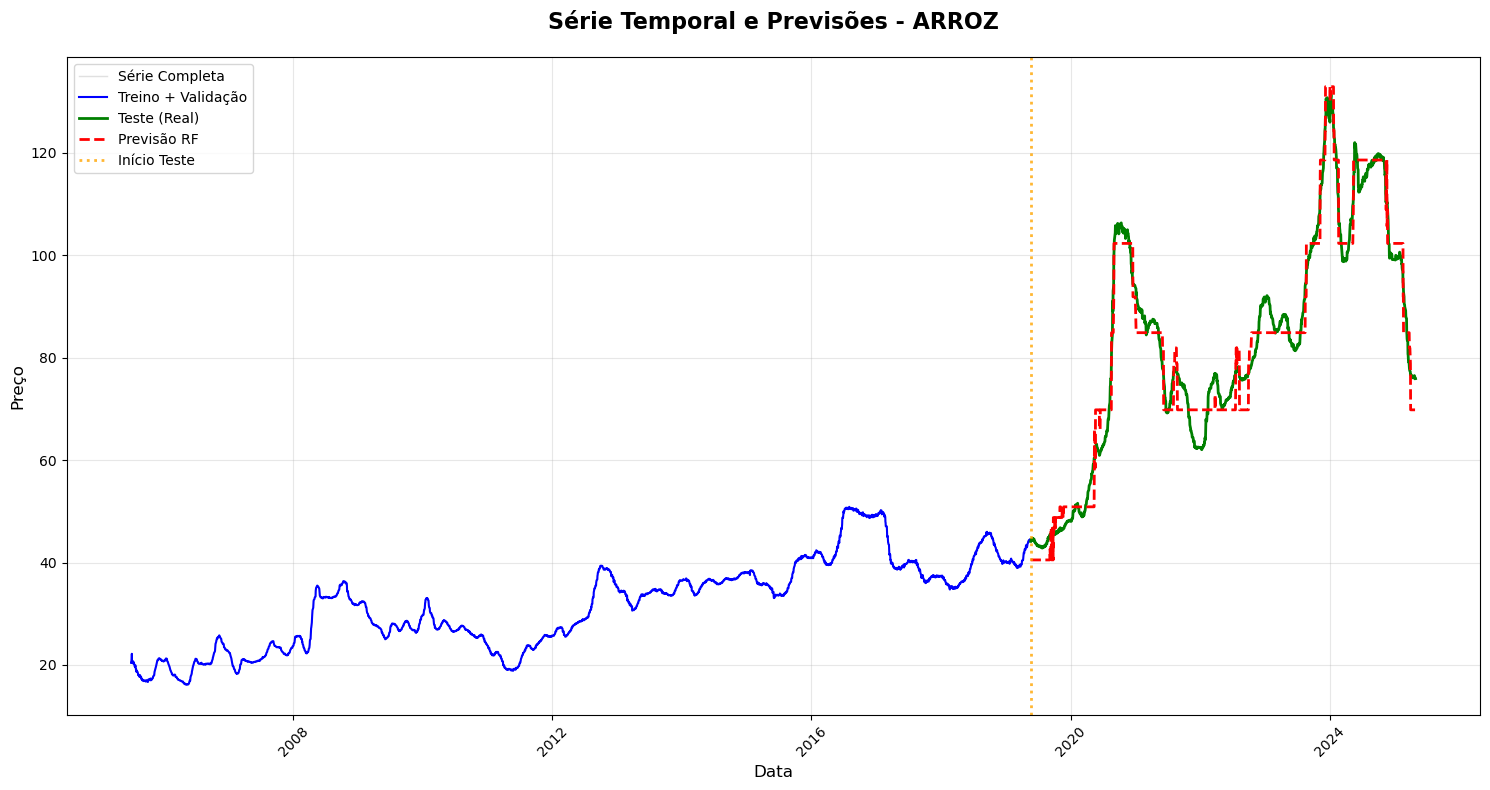

Gráfico exibido para: ARROZ
--------------------------------------------------


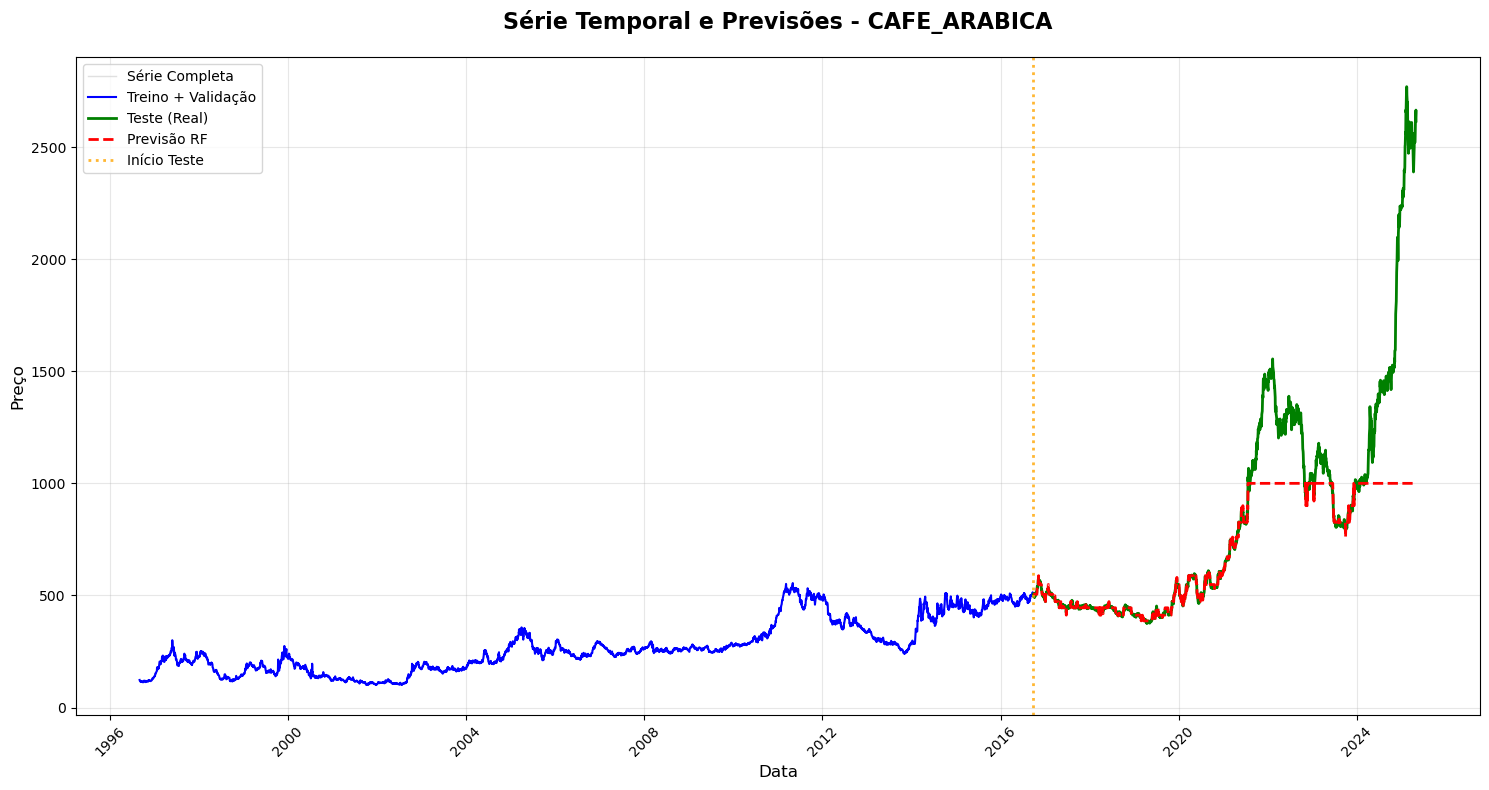

Gráfico exibido para: CAFE_ARABICA
--------------------------------------------------


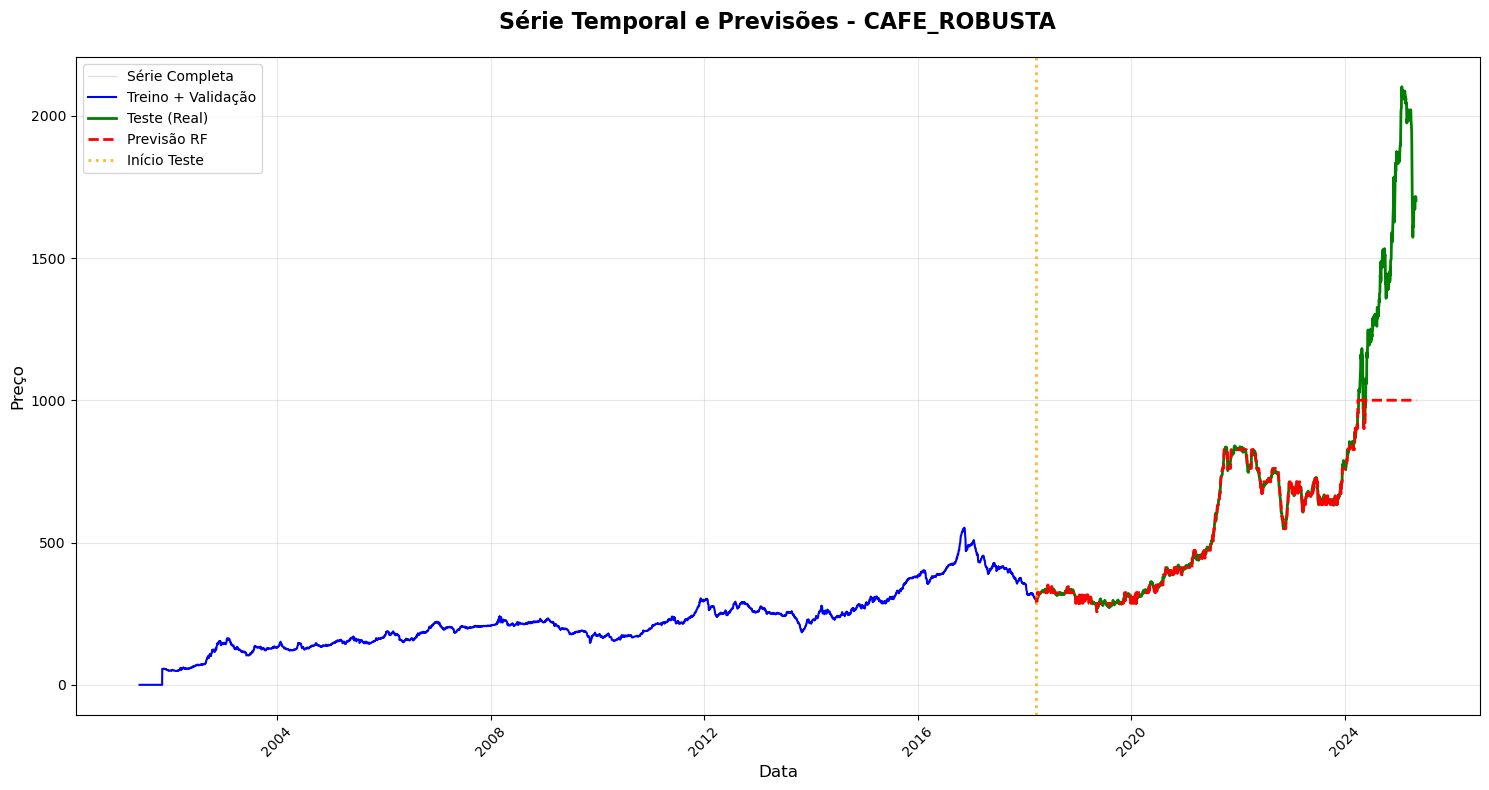

Gráfico exibido para: CAFE_ROBUSTA
--------------------------------------------------


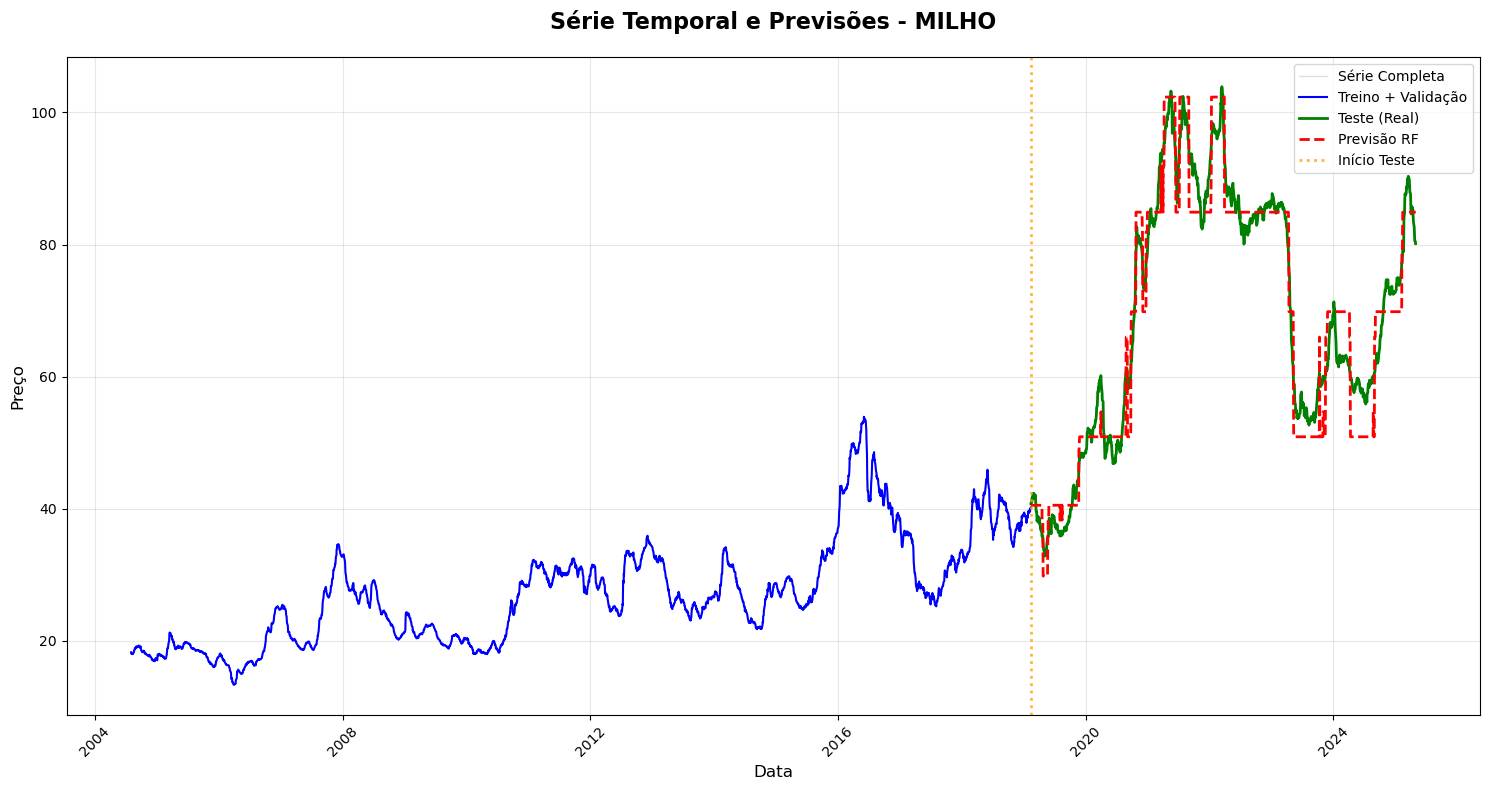

Gráfico exibido para: MILHO
--------------------------------------------------


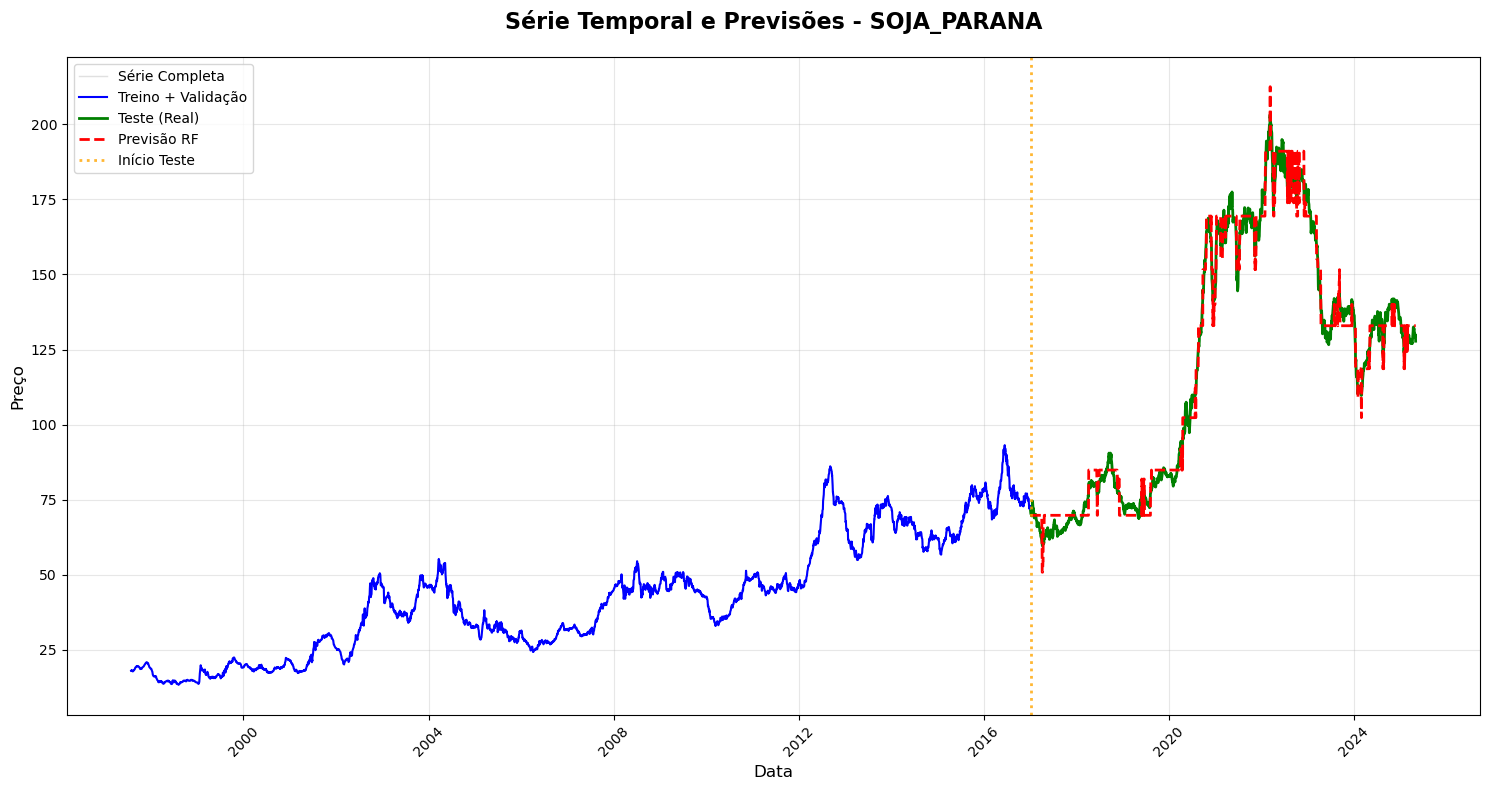

Gráfico exibido para: SOJA_PARANA
--------------------------------------------------


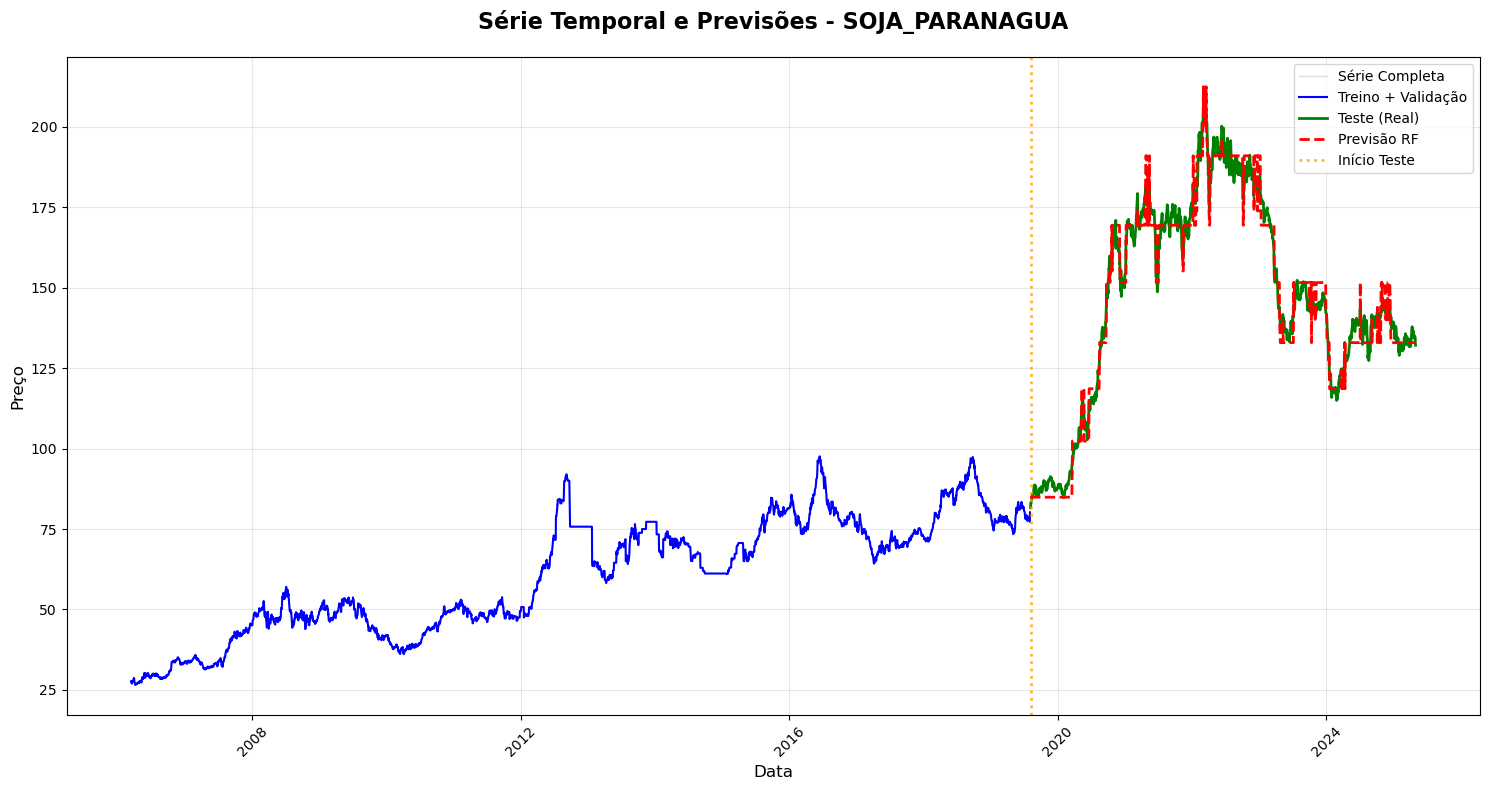

Gráfico exibido para: SOJA_PARANAGUA
--------------------------------------------------


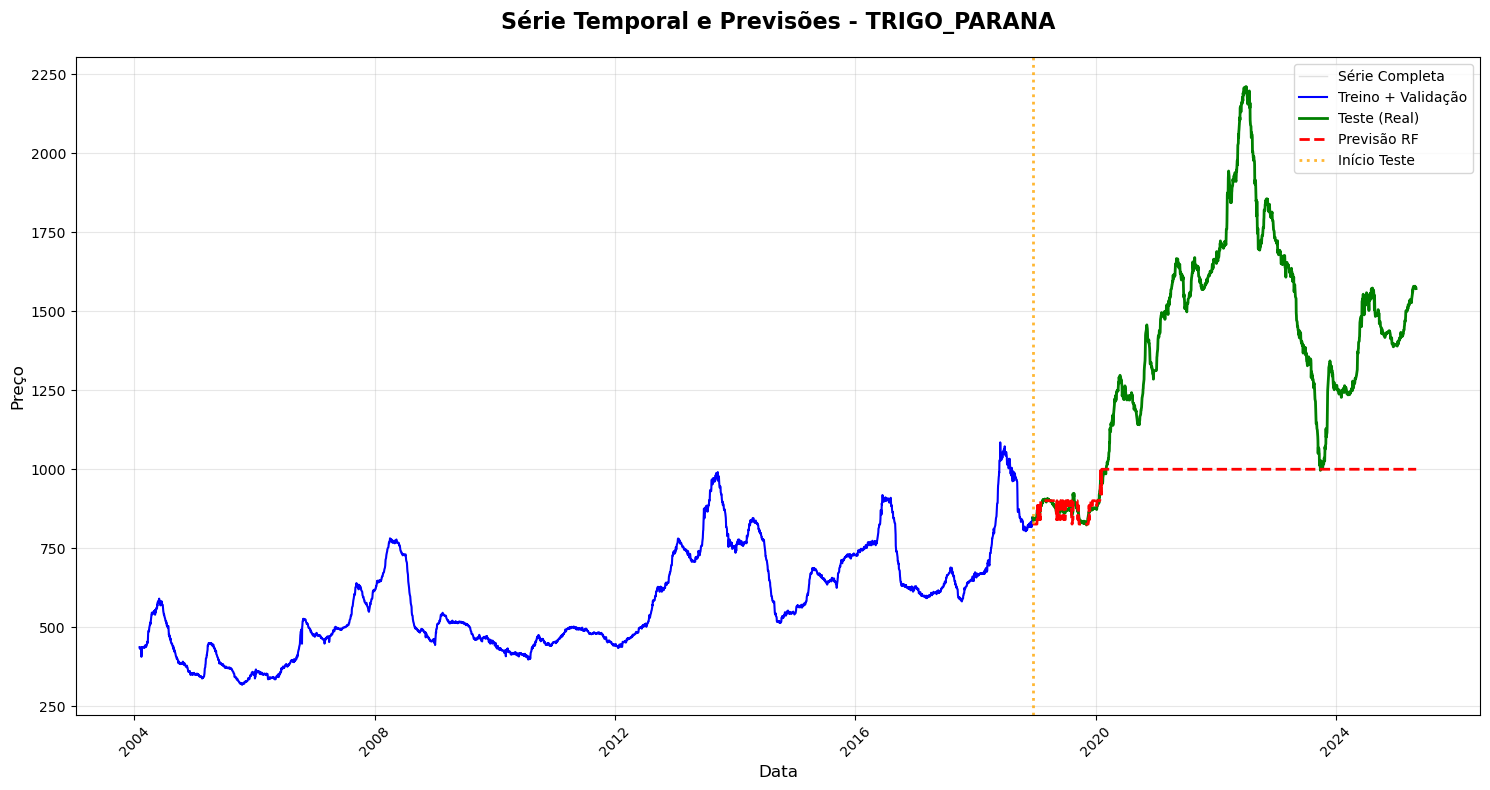

Gráfico exibido para: TRIGO_PARANA
--------------------------------------------------


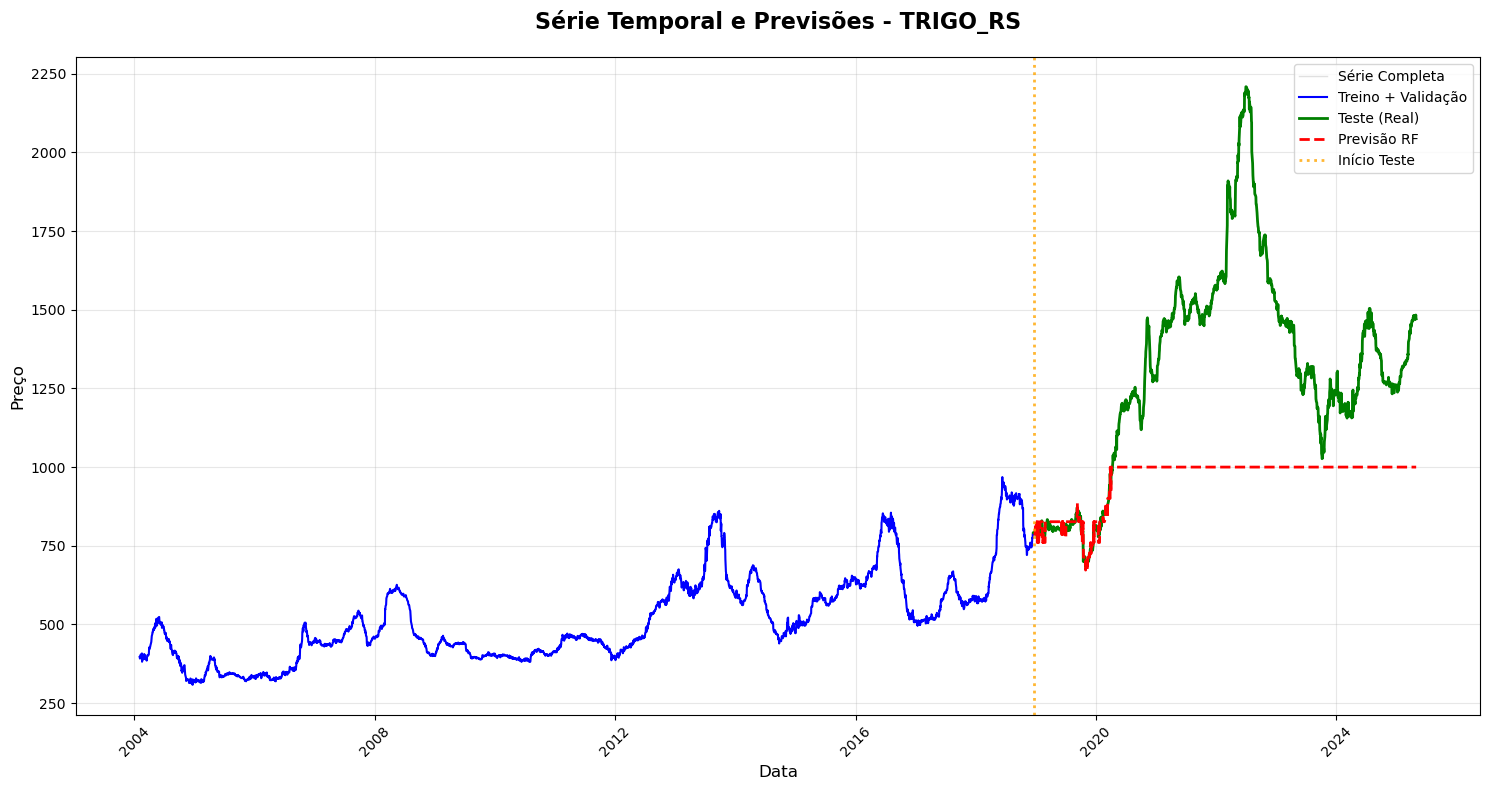

Gráfico exibido para: TRIGO_RS
--------------------------------------------------


In [50]:
def plot_series_and_forecasts(df_brl, full_train, test, forecasts_df):
    """
    Plota a série completa e as previsões para cada commodity individualmente
    """
    unique_ids = df_brl['unique_id'].unique()
    
    for uid in unique_ids:
        fig, ax = plt.subplots(1, 1, figsize=(15, 8))
        
        series_data = df_brl[df_brl['unique_id'] == uid].copy()
        train_data = full_train[full_train['unique_id'] == uid].copy()
        test_data = test[test['unique_id'] == uid].copy()
        forecast_data = forecasts_df[forecasts_df['unique_id'] == uid].copy()
        
        ax.plot(series_data['ds'], series_data['y'], 
                color='lightgray', alpha=0.7, linewidth=1, label='Série Completa')
        
        ax.plot(train_data['ds'], train_data['y'], 
                color='blue', linewidth=1.5, label='Treino + Validação')
        
        ax.plot(test_data['ds'], test_data['y'], 
                color='green', linewidth=2, label='Teste (Real)')
        
        ax.plot(forecast_data['ds'], forecast_data['rf'], 
                color='red', linewidth=2, linestyle='--', label='Previsão RF')
        
        if len(test_data) > 0:
            ax.axvline(x=test_data['ds'].iloc[0], color='orange', 
                      linestyle=':', alpha=0.8, linewidth=2, label='Início Teste')
        
        ax.set_title(f'Série Temporal e Previsões - {uid}', 
                    fontsize=16, fontweight='bold', pad=20)
        ax.set_xlabel('Data', fontsize=12)
        ax.set_ylabel('Preço', fontsize=12)
        ax.legend(fontsize=10, loc='best')
        ax.grid(True, alpha=0.3)
        
        ax.tick_params(axis='x', rotation=45)
        
        plt.tight_layout()
        
        plt.show()
        
        print(f"Gráfico exibido para: {uid}")
        print("-" * 50)

plot_series_and_forecasts(df_brl, full_train, test, forecasts_df)